In [1]:
import torch
import torch.nn as nn
import math

In [ ]:
class PositionalEncoding(nn.Module):
    """
    位置编码模块
    """
    def __init__(self, d_model:int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x):
        pass

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    多头注意力机制模块
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model 必须能被 num_heads 整除"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # 定义 Q, K, V 和输出的线性变换层
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # 1. 计算注意力得分 (QK^T)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # 2. 应用掩码 (如果提供)
        if mask is not None:
            # 将掩码中为 0 的位置设置为一个非常小的负数，这样 softmax 后会接近 0
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # 3. 计算注意力权重 (Softmax)
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # 4. 加权求和 (权重 * V)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # 将输入 x 的形状从 (batch_size, seq_length, d_model)
        # 变换为 (batch_size, num_heads, seq_length, d_k)
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # 将输入 x 的形状从 (batch_size, num_heads, seq_length, d_k)
        # 变回 (batch_size, seq_length, d_model)
        batch_size, num_heads, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # 1. 对 Q, K, V 进行线性变换
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # 2. 计算缩放点积注意力
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # 3. 合并多头输出并进行最终的线性变换
        output = self.W_o(self.combine_heads(attn_output))
        return output


In [ ]:
class PositionWiseFeedForward(nn.Module):
    """
    位置前馈神经网络模块
    """
    def __init__(self, d_model, d_ff, dorpout=0.1):
        super(PositionWiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x 形状: (batch_size, seq_len, d_model)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        # 最终输出形状: (batch_size, seq_len, d_model)
        return x

-------- 编码器核心层 --------

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention()
        self.feed_forward = PositionWiseFeedForward()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x,x,x,mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

-------- 解码器核心层 --------

 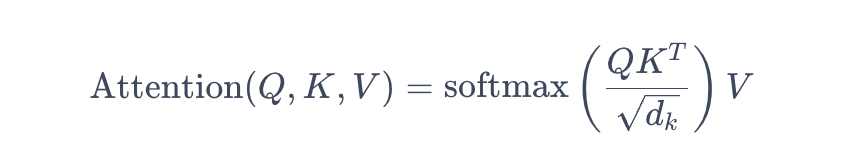\
Q：当前词元的embedding 经过 WQ后的结果\
K: 可以被查询到的词元的embedding 经过 WK后的结果\
V: 可以被查询到的词元的embedding 经过 WV后的结果，词元本身所蕴含的信息

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        解码器层的实现，包含掩码多头自注意力、交叉注意力和前馈神经网络。
        参数:
        - d_model: 模型的维度，也是输入和输出的维度。
        - num_heads: 多头注意力机制中的头数。
        - d_ff: 前馈神经网络的隐藏层维度。
        - dropout:  dropout 率，用于正则化，防止过拟合。
        """
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention()
        self.cross_attn = MultiHeadAttention()
        self.feed_forward = PositionWiseFeedForward()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        # 1. 掩码多头自注意力
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))

        # 2. 交叉注意力
        cross_attn_output = self.cross_attn(x, encoder_output, encoder_output, src_mask)
        x = self.norm2(x + self.dropout(cross_attn_output))

        # 3. 前馈神经网络
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))

        return x

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "Qwen/Qwen1.5-0.5B-Chat"

/Users/edwardchan/miniconda3/envs/DL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

print("模型和分词器加载完成！")

模型和分词器加载完成！


In [4]:
# 准备对话输入
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "你好，请介绍你自己。"}
]
# 使用分词器的模板格式化输入
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

In [6]:
model_inputs = tokenizer([text], return_tensors="pt").to(device)
print(model_inputs)

{'input_ids': tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198, 108386,  37945, 100157, 107828,
           1773, 151645,    198, 151644,  77091,    198]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [7]:
generated_ids = model.generate(
    model_inputs.input_ids,
    max_new_tokens = 512
)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [8]:
print(generated_ids)

tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198, 108386,  37945, 100157, 107828,
           1773, 151645,    198, 151644,  77091,    198, 111308,   6313,  35946,
          99882,  31935,  64559,  99320,  56007,   3837, 104625, 102661,  99718,
         100048,   9370,  98841, 104034, 102064, 104949,   1773,  97611,  99558,
          98380,  20412, 100006, 102104,  86119,   5373, 104223,  87335,   3837,
         104246, 102124, 101313,   5373, 110479,  46100,  49567,   1773, 106870,
         110117,  86119,  57191,  85106, 100364,  37945, 102422, 106525,   3837,
         105351, 110121,  99553, 100143,   1773, 151645]])


In [9]:
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]
generated_ids

[tensor([111308,   6313,  35946,  99882,  31935,  64559,  99320,  56007,   3837,
         104625, 102661,  99718, 100048,   9370,  98841, 104034, 102064, 104949,
           1773,  97611,  99558,  98380,  20412, 100006, 102104,  86119,   5373,
         104223,  87335,   3837, 104246, 102124, 101313,   5373, 110479,  46100,
          49567,   1773, 106870, 110117,  86119,  57191,  85106, 100364,  37945,
         102422, 106525,   3837, 105351, 110121,  99553, 100143,   1773, 151645])]

In [10]:
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(response)

您好！我叫通义千问，是由阿里云研发的预训练语言模型。我的主要功能是能够回答问题、创作文字，还能表达观点、撰写代码等。如果您有任何问题或需要帮助，请随时告诉我，我会尽力提供支持。
